In [ ]:
def calc_nsteps(dt,num_lambdas,ns_perLambda):
    # steps = ?
    # 1000 ps = 1 ns
    factor = 1000
    # want the answer in # of steps
    return num_lambdas*ns_perLambda*factor/dt


"""
Reference:
If dt = 0.001,
if you want 1ns per lambda
and you have 21 lambdas,
then nsteps = 21000000 ; 1 ns per lambda

If you are just running a normal sim then 
num_lambdas = 1
"""

# time step
dt = 0.001

# how many lambdas?
# 1 if running normal sims
num_lambdas = 1

# how many ns per lambda? CHANGE THIS!!!
# 500 ps = 0.5 ns, 250 ps = 0.25 ns
# unit is ns
ns_per_lambda = 0.5

calc_nsteps(dt, num_lambdas, ns_per_lambda)

In [1]:
# General syntax to import a library but no functions: 
#import (library) as (give the library a nickname/alias)
import pandas as pd
from pandas import DataFrame, read_csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.style.use('ggplot')

from scipy import stats

# Enable inline plotting
%matplotlib inline
matplotlib.rcParams["figure.facecolor"] = 'white'
matplotlib.rcParams["savefig.facecolor"] = 'white'
matplotlib.rcParams["figure.edgecolor"] = 'black'
matplotlib.rcParams["axes.edgecolor"] = 'black'
matplotlib.rcParams["axes.facecolor"] = 'white'


"""
Create a function that calculates AIM from the output of the log file

This output is generated by Gromacs with AIM in the log file.

  1  0.000  0.000    10448    0.00000   -0.02861  72.74402 -38.80195
  2  0.200  0.000    10246   -0.02861    0.03107  48.73083 -10.09811
  3  0.400  0.000    10864    0.00247   -0.02543  30.36052   4.23614
  4  0.600  0.000    10751   -0.02297   -0.04503  16.18198  11.43519
  5  0.800  0.000    10765   -0.06800   -0.06085   6.97454  13.26155
  6  1.000  0.000    10483   -0.12885    0.00558   0.18699  14.00396
  ...
  

For each log output I extract the output using bash cli:

for i in 1 2 3 4 5;
do;
$tail -135 out0$i.log | grep -A 21 " | tr -d '<<' >> aimgpu0$i.out;
done

I then moved the files over to my laptop and made sure the format was correct.

"""
def quad_AIM(file_in=None, names=None):
    # import the copied averages from the AIM simu
    location = file_in
    myDeltaG = pd.read_csv(
        location, 
        header = None,
        names = names,
        delim_whitespace=True)

    # only need the average values from the copied info
    dGdcoul = myDeltaG.dGCoulL
    dGdvdw = myDeltaG.dGVdwL
    coulLambdas = myDeltaG.CoulL
    vdwLambdas = myDeltaG.VdwL

    # we only need the delta lambdas so we don't need a 2d array here
    dlamCoul = np.diff(coulLambdas, axis=0)
    dlamVdw = np.diff(vdwLambdas, axis=0)

    lv = []
    ave_dhdl = []
    for i in range(len(coulLambdas)):
        lv.append([coulLambdas[i], vdwLambdas[i]])
        ave_dhdl.append([dGdcoul[i], dGdvdw[i]])

    lv = np.array(lv)
    ave_dhdl = np.array(ave_dhdl)
    K, n_components = lv.shape
    lchange = get_lchange(lv, K, n_components)
    cubspl, mapl = getSplines(lchange, K, n_components, lv)

    dlam = []
    for i in range(len(dlamCoul)):
        dlam.append([dlamCoul[i], dlamVdw[i]])
    dlam = np.array(dlam)

    aim = 0
    aimcubic = 0.0
    for k in range(K-1):
        aim += 0.5*np.dot(dlam[k],(ave_dhdl[k]+ave_dhdl[k+1]))
        for j in range(n_components):
            if dlam[k,j] > 0:
                lj = lchange[:,j]
                aimcubic += np.dot(cubspl[j].wk[mapl[k,j]],ave_dhdl[lj,j])
                
    return(aim, aimcubic)

def hist_flatness(counts, sim_label=None):
    """
    Expects an array of counts and a label
    """
    ###############################################################################
    # Is it flat enough?  Is the minimum entry less than 80% of its average value?
    # It is common practice to considr a histogram "sufficiently flat" when its
    # minimum entry is no less than 80% of its average value.
    ###############################################################################
    dfnum = np.array(counts)
    flatness = 100*(min(dfnum)/np.average(dfnum))
    if flatness > 80:
        flat = "It's flat"
    else:
        flat = "Not flat"

    plt.title("Lambda Histogram", fontsize=22)
    plt.grid(True)
    plt.grid(color='gray', linestyle='-', linewidth=0.2)
    plt.xlabel("Lambda Values", fontsize=22)
    plt.ylabel("AIM Count at Lambda", fontsize=22)
    plt.xlim(-0.01,1.02)
    plt.ylim(0.5*min(dfnum),2*max(dfnum))
    x = np.linspace(0,1,len(dfnum))
    y = dfnum
    plt.plot(x, y,label="sim "+sim_label+" "+flat)
    legend = plt.legend(loc='upper center')
        

# Taken without remorse from
# https://github.com/MobleyLab/alchemical-analysis/blob/master/alchemical_analysis/alchemical_analysis.py
class naturalcubicspline:

    def __init__(self, x):

        # define some space
        L = len(x)
        H = np.zeros([L,L],float)
        M = np.zeros([L,L],float)
        BW = np.zeros([L,L],float)
        AW = np.zeros([L,L],float)
        DW = np.zeros([L,L],float)

        h = x[1:L]-x[0:L-1]
        ih = 1.0/h

        # define the H and M matrix, from p. 371 "applied numerical methods with matlab, Chapra"
        H[0,0] = 1
        H[L-1,L-1] = 1
        for i in range(1,L-1):
            H[i,i] = 2*(h[i-1]+h[i])
            H[i,i-1] = h[i-1]
            H[i,i+1] = h[i]

            M[i,i] = -3*(ih[i-1]+ih[i])
            M[i,i-1] = 3*(ih[i-1])
            M[i,i+1] = 3*(ih[i])

        CW = np.dot(np.linalg.inv(H),M)  # this is the matrix translating c to weights in f.
                                                       # each row corresponds to the weights for each c.

        # from CW, define the other coefficient matrices
        for i in range(0,L-1):
            BW[i,:]    = -(h[i]/3)*(2*CW[i,:]+CW[i+1,:])
            BW[i,i]   += -ih[i]
            BW[i,i+1] += ih[i]
            DW[i,:]    = (ih[i]/3)*(CW[i+1,:]-CW[i,:])
            AW[i,i]    = 1

        # Make copies of the arrays we'll be using in the future.
        self.x  = x.copy()
        self.AW = AW.copy()
        self.BW = BW.copy()
        self.CW = CW.copy()
        self.DW = DW.copy()

        # find the integrating weights
        self.wsum = np.zeros([L],float)
        self.wk = np.zeros([L-1,L],float)
        for k in range(0,L-1):
            w = DW[k,:]*(h[k]**4)/4.0 + CW[k,:]*(h[k]**3)/3.0 + BW[k,:]*(h[k]**2)/2.0 + AW[k,:]*(h[k])
            self.wk[k,:] = w
            self.wsum += w

    def interpolate(self,y,xnew):
        if len(self.x) != len(y):
            parser.error("\nThe length of 'y' should be consistent with that of 'self.x'. I cannot perform linear algebra operations.")
        # get the array of actual coefficients by multiplying the coefficient matrix by the values
        a = np.dot(self.AW,y)
        b = np.dot(self.BW,y)
        c = np.dot(self.CW,y)
        d = np.dot(self.DW,y)

        N = len(xnew)
        ynew = np.zeros([N],float)
        for i in range(N):
            # Find the index of 'xnew[i]' it would have in 'self.x'.
            j = np.searchsorted(self.x, xnew[i]) - 1
            lamw = xnew[i] - self.x[j]
            ynew[i] = d[j]*lamw**3 + c[j]*lamw**2 + b[j]*lamw + a[j]
        # Preserve the terminal points.
        ynew[0] = y[0]
        ynew[-1] = y[-1]
        return ynew

def get_lchange(lv, K, n_components):
    lchange = np.zeros([K,n_components],bool)   # booleans for which lambdas are changing
    for j in range(n_components):
        # need to identify range over which lambda doesn't change, and not interpolate over that range.
        for k in range(K-1):
            if (lv[k+1,j]-lv[k,j] > 0):
                lchange[k,j] = True
                lchange[k+1,j] = True
    return lchange

def getSplines(lchange, K, n_components, lv):
    # construct a map back to the original components
    mapl = np.zeros([K,n_components],int)   # map back to the original k from the components
    for j in range(n_components):
        incr = 0
        for k in range(K):
            if (lchange[k,j]):
                mapl[k,j] += incr
                incr +=1

    # put together the spline weights for the different components
    cubspl = list()
    for j in range(n_components):
        lv_lchange = lv[lchange[:,j],j]
        if len(lv_lchange) == 0: # handle the all-zero lv column
            cubspl.append(0)
        else:
            spl = naturalcubicspline(lv_lchange)
            cubspl.append(spl)
    return cubspl, mapl

def import_pickle(root, runs):
    results = pd.DataFrame()
    for j in runs:
        # import the pickled resuls from pymbar
        location = root+"/{0}/results.pickle".format(j)
        with open(location, 'rb') as handle:
            unserialized_data = pickle.load(handle)

        # convert the values from k_BT to kJ/mol
        # store in a new dictionary
        new_dict = dict()
        for i in unserialized_data.dFs[2]:
             new_dict[i] = unserialized_data.dFs[2][i]*2.4947

        # place the values into a dataframe
        df = pd.DataFrame([new_dict], columns=new_dict.keys())
        results = pd.concat([results, df],ignore_index=True)
    return(results)

def plot_errorbars(results=None, save=False, save_file=None, ymin=20, ymax=22.5):
    """
    Expects a dataframe of values
    Use Pymbar to get the results
    make sure to skip half of the xvg file
    Command line was: /Users/ChrisM/anaconda/bin/alchemical_analysis -t 300 -x -v -p prod -s 500 -i 0

    Get the result from each run to look like this
    5 ns
            TI  TI-CUBIC DEXP    IEXP    BAR  MBAR    AIM
    run01 18.782 18.524 18.349 18.633 18.522 18.510 15.22232
    run02 18.776 18.496 18.398 18.538 18.535 18.561 15.34766
    run03 18.665 18.404 18.218 18.541 18.402 18.438 15.39739
    run04 18.679 18.410 18.382 18.594 18.417 18.471 15.20885
    run05 18.679 18.400 18.316 18.543 18.408 18.441 15.09506
    Plot the results using error bars for each lambda window 1ns, 5ns, 10ns
    """

    plt.close()
    labels = results.columns
    y = np.array(results.mean().values)
    x = range(len(y))
    plt.close()
    plt.xticks(x, labels, rotation='vertical')
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.5)
    plt.ylabel("$\Delta$G (kJ/mol)", fontsize = 20)
    plt.xlabel('Method', fontsize = 20)
    plt.errorbar(x, y, yerr=np.std(results), fmt=None)
    plt.scatter(x, y)
    plt.ylim(ymin, ymax)


    # Create a simple legend
    plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1)
    plt.style.use('ggplot')
    plt.show()
    if save:
        # Finally, save the figure as a png.  
        # You can also save it as a PDF, JPEG, etc.  
        # Just change the file extension in this call.  
        # bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
        plt.savefig(save_file+".png", bbox_inches="tight", dpi=300);
    

/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [11]:
# collect all of the TI information
import pickle
runs = ["run01","run02","run03","run04","run05"]
ti_home = "/Users/ChrisM/Documents/workspace/TI/"
times = ["100ps", "250ps", "500ps","1ns","5ns","10ns"]

# create a dictionary to hold our results
# each result is a dataframe
results = {}
for i in times:
    root = ti_home+i
    results[i] = import_pickle(root, runs)

In [12]:
# collect AIM results
# need the lambda arrays
times = ['1ns','5ns','10ns']
names = ["N","CoulL","VdwL","Count","G","dG","dGCoulL","dGVdwL"]

for j in times:
    totals = []
    cubics = []
    for i in range(5):
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}/aimgpu0{1}.out".format(j, str(i+1))
        aim, aim_cubic = quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)


In [13]:
# collect AIM results
# need the lambda arrays
times = ['100ps','250ps','500ps']
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]

for j in times:
    totals = []
    cubics = []
    for i in range(5):
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}/aimgpu0{1}.out".format(j, str(i+1))
        aim, aim_cubic = quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)


100ps


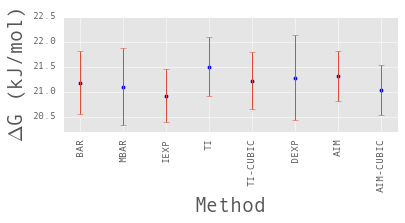

250ps


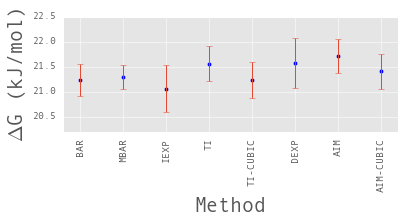

500ps


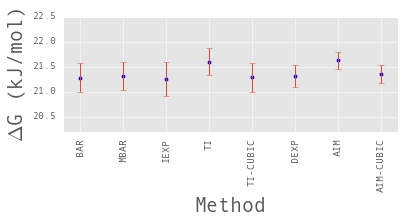

1ns


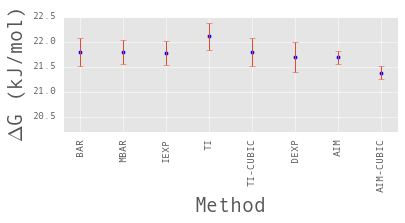

5ns


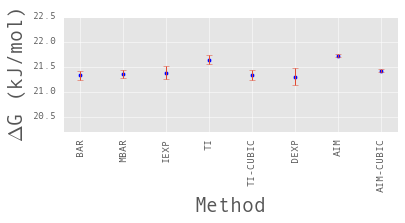

10ns


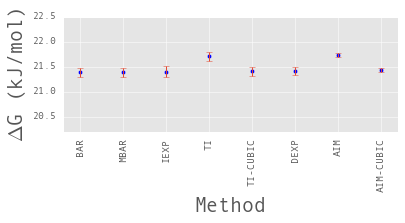

In [17]:
# plot the error bars
times = ['100ps','250ps','500ps','1ns','5ns','10ns']

for j in times:
    print(j)
    plot_errorbars(results[j],ymin=20.2, ymax=22.5)

100ps


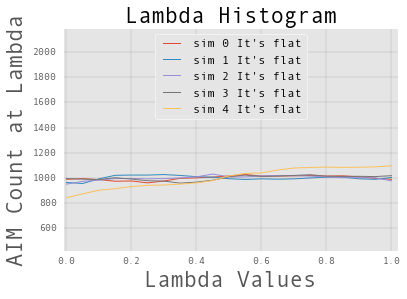

The average is  21.31524445
The cubic average is  21.0336143043


250ps


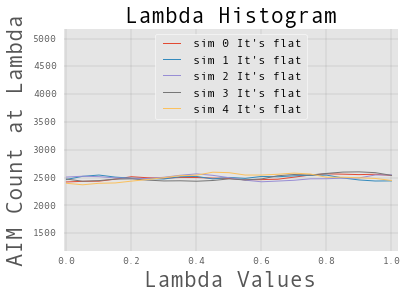

The average is  21.71243625
The cubic average is  21.4049693077


500ps


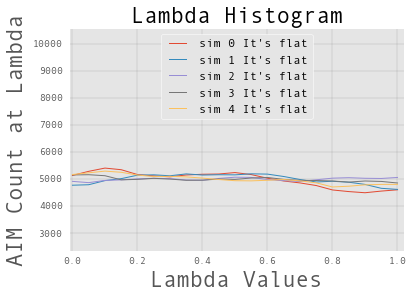

The average is  21.62730495
The cubic average is  21.3460519663


1ns


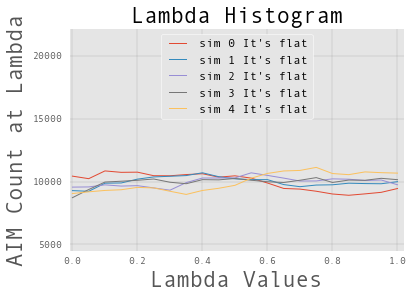

The average is  21.6882475
The cubic average is  21.381655131


5ns


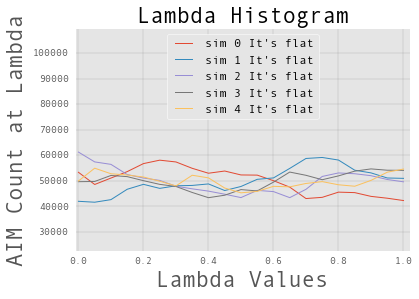

The average is  21.72097895
The cubic average is  21.4207220377


10ns


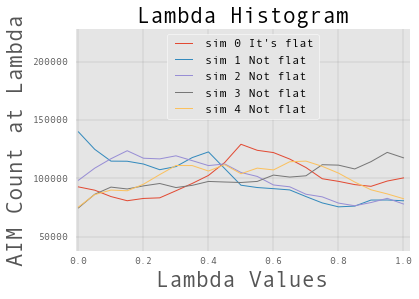

The average is  21.73400475
The cubic average is  21.4305795482




In [18]:
# need the lambda arrays
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
times = ['100ps','250ps','500ps']

for j in times:
    print(j)
    for i in range(5):
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}/aimgpu0{1}.out".format(j, str(i+1))
        myDeltaG = pd.read_csv(
            file_in, 
            header = None,
            names = names,
            delim_whitespace=True)
        counts = myDeltaG.AIMCount.tolist()
        hist_flatness(counts, str(i))
    plt.show()
    print "The average is ",results[j]['AIM'].mean()
    print "The cubic average is ",results[j]['AIM-CUBIC'].mean()
    print("\n")

# need the lambda arrays
names = ["N","CoulL","VdwL","Count","G","dG","dGCoulL","dGVdwL"]
times = ['1ns','5ns','10ns']

for j in times:
    print(j)
    for i in range(5):
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}/aimgpu0{1}.out".format(j, str(i+1))
        myDeltaG = pd.read_csv(
            file_in, 
            header = None,
            names = names,
            delim_whitespace=True)
        counts = myDeltaG.Count.tolist()
        hist_flatness(counts, str(i))
    plt.show()
    print "The average is ",results[j]['AIM'].mean()
    print "The cubic average is ",results[j]['AIM-CUBIC'].mean()
    print("\n")

/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2748: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


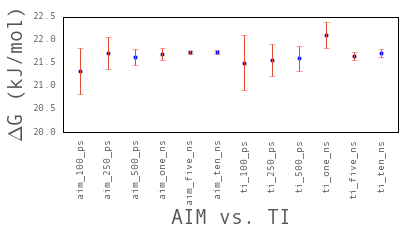

In [15]:
# Use Pymbar to get the results
# make sure to skip half of the xvg file
# Command line was: /Users/ChrisM/anaconda/bin/alchemical_analysis -t 300 -x -v -p prod -s 500 -i 0

# Get the result from each run to look like this
# 5 ns
#         TI  TI-CUBIC DEXP    IEXP    BAR  MBAR    AIM
# run01 18.782 18.524 18.349 18.633 18.522 18.510 15.22232
# run02 18.776 18.496 18.398 18.538 18.535 18.561 15.34766
# run03 18.665 18.404 18.218 18.541 18.402 18.438 15.39739
# run04 18.679 18.410 18.382 18.594 18.417 18.471 15.20885
# run05 18.679 18.400 18.316 18.543 18.408 18.441 15.09506

# Plot the results using error bars for each lambda window
df = pd.DataFrame()
df['aim_100_ps'] = np.array(results['100ps']['AIM'])
df['aim_250_ps'] = np.array(results['250ps']['AIM'])
df['aim_500_ps'] = np.array(results['500ps']['AIM'])
df['aim_one_ns'] = np.array(results['1ns']['AIM'])
df['aim_five_ns'] = np.array(results['5ns']['AIM'])
df['aim_ten_ns'] = np.array(results['10ns']['AIM'])
df['ti_100_ps'] = np.array(results['100ps']['TI'])
df['ti_250_ps'] = np.array(results['250ps']['TI'])
df['ti_500_ps'] = np.array(results['500ps']['TI'])
df['ti_one_ns'] = np.array(results['1ns']['TI'])
df['ti_five_ns'] = np.array(results['5ns']['TI'])
df['ti_ten_ns'] = np.array(results['10ns']['TI'])
plt.close()
labels = list(df.columns.values)
y = np.array(df.mean().values)
x = range(len(y))
plt.close()
plt.xticks(x, labels, rotation='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.5)
plt.ylabel("$\Delta$G (kJ/mol)", fontsize = 20)
plt.xlabel('AIM vs. TI', fontsize = 20)
plt.errorbar(x, y, yerr=np.std(df), fmt=None)
plt.scatter(x, y)
plt.ylim(20.0, 22.5)

# Create a simple legend
plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1)
plt.style.use('ggplot')

# Finally, save the figure as a png.  
# You can also save it as a PDF, JPEG, etc.  
# Just change the file extension in this call.  
# bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
plt.savefig("all_compared.png", bbox_inches="tight", dpi=300);

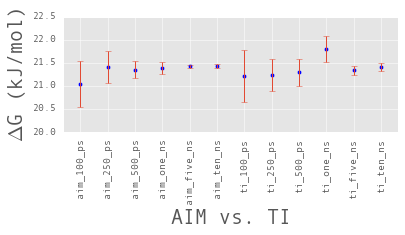

In [16]:
# Use Pymbar to get the results
# make sure to skip half of the xvg file
# Command line was: /Users/ChrisM/anaconda/bin/alchemical_analysis -t 300 -x -v -p prod -s 500 -i 0

# Get the result from each run to look like this
# 5 ns
#         TI  TI-CUBIC DEXP    IEXP    BAR  MBAR    AIM
# run01 18.782 18.524 18.349 18.633 18.522 18.510 15.22232
# run02 18.776 18.496 18.398 18.538 18.535 18.561 15.34766
# run03 18.665 18.404 18.218 18.541 18.402 18.438 15.39739
# run04 18.679 18.410 18.382 18.594 18.417 18.471 15.20885
# run05 18.679 18.400 18.316 18.543 18.408 18.441 15.09506

# Plot the results using error bars for each lambda window
df = pd.DataFrame()
df['aim_100_ps'] = np.array(results['100ps']['AIM-CUBIC'])
df['aim_250_ps'] = np.array(results['250ps']['AIM-CUBIC'])
df['aim_500_ps'] = np.array(results['500ps']['AIM-CUBIC'])
df['aim_one_ns'] = np.array(results['1ns']['AIM-CUBIC'])
df['aim_five_ns'] = np.array(results['5ns']['AIM-CUBIC'])
df['aim_ten_ns'] = np.array(results['10ns']['AIM-CUBIC'])
df['ti_100_ps'] = np.array(results['100ps']['TI-CUBIC'])
df['ti_250_ps'] = np.array(results['250ps']['TI-CUBIC'])
df['ti_500_ps'] = np.array(results['500ps']['TI-CUBIC'])
df['ti_one_ns'] = np.array(results['1ns']['TI-CUBIC'])
df['ti_five_ns'] = np.array(results['5ns']['TI-CUBIC'])
df['ti_ten_ns'] = np.array(results['10ns']['TI-CUBIC'])
plt.close()
labels = list(df.columns.values)
y = np.array(df.mean().values)
x = range(len(y))
plt.close()
plt.xticks(x, labels, rotation='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.5)
plt.ylabel("$\Delta$G (kJ/mol)", fontsize = 20)
plt.xlabel('AIM vs. TI', fontsize = 20)
plt.errorbar(x, y, yerr=np.std(df), fmt=None)
plt.scatter(x, y)
plt.ylim(20.0, 22.5)

# Create a simple legend
plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1)
plt.style.use('ggplot')

# Finally, save the figure as a png.  
# You can also save it as a PDF, JPEG, etc.  
# Just change the file extension in this call.  
# bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
#plt.savefig("all_compared.png", bbox_inches="tight", dpi=300);

In [ ]:
# if next not equal to current increment count by one
# acceptance equals count/total * 100
import pandas as pd
def getAcceptance(file_in):
    steps = pd.read_csv(file_in,
                        header=None,
                        delim_whitespace=True)

    count = 0
    for i in range(len(steps)-1):
        if steps[0][i+1] != steps[0][i]:
            count = count + 1

    return(float(count)/len(steps)*100)

oneHun = getAcceptance("/Users/ChrisM/Documents/workspace/100steps.log")
oneThou = getAcceptance("/Users/ChrisM/Documents/workspace/1000steps.log")
tenThou = getAcceptance("/Users/ChrisM/Documents/workspace/10000steps.log")
oneHThou = getAcceptance("/Users/ChrisM/Documents/workspace/100000steps.log")
oneMil = getAcceptance("/Users/ChrisM/Documents/workspace/1milsteps.log")

In [98]:
print(oneHun, oneThou, tenThou, oneHThou, oneMil)

(52.0, 55.800000000000004, 64.38000000000001, 69.952, 72.4777)


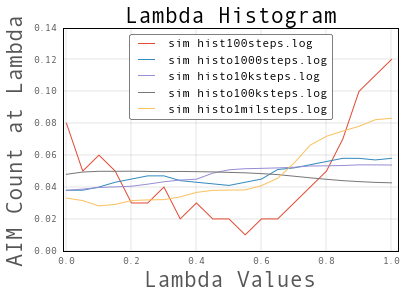

In [3]:
filenames=["hist100steps.log","histo1000steps.log","histo10ksteps.log","histo100ksteps.log","histo1milsteps.log"]
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]

for j in filenames:
    file_in = "/Users/ChrisM/Documents/workspace/{0}".format(j)
    myHisto = pd.read_csv(
        file_in, 
        header = None,
        names = names,
        comment = '#',
        delim_whitespace=True)
    #counts = myHisto['AIMCount'].astype(np.float)
    chi = np.array(myHisto['AIMCount'])
    counts = [float(i)/chi.sum() for i in chi]
    plt.title("Lambda Histogram", fontsize=22)
    plt.grid(True)
    plt.grid(color='gray', linestyle='-', linewidth=0.2)
    plt.xlabel("Lambda Values", fontsize=22)
    plt.ylabel("AIM Count at Lambda", fontsize=22)
    plt.xlim(-0.01,1.02)
    #plt.ylim(-2.5, 5)
    x = np.linspace(0,1,len(counts))
    y = counts
    plt.plot(x, y,label="sim "+j)
    legend = plt.legend(loc='upper center')


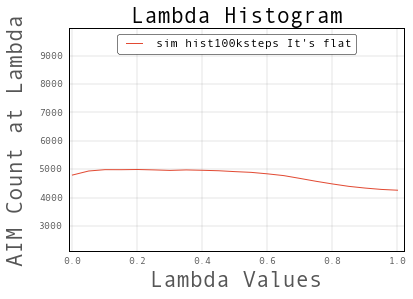

In [6]:
file_in = "/Users/ChrisM/Documents/workspace/histo100ksteps.log"
myHisto = pd.read_csv(
    file_in, 
    header = None,
    names = names,
    comment = '#',
    delim_whitespace=True)
counts = myHisto['AIMCount'].astype(np.float)
#counts = (x - x.min())/(x.max() - x.min())
hist_flatness(counts, "hist100ksteps")

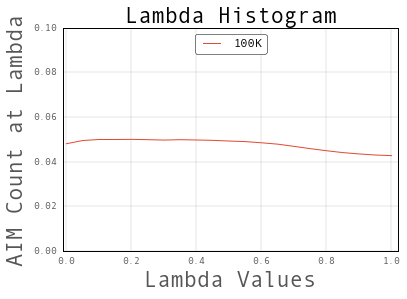

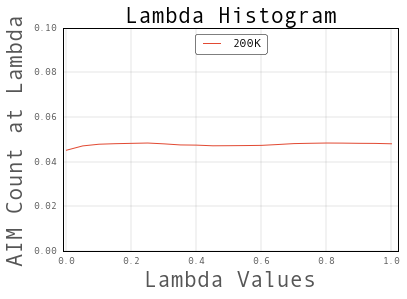

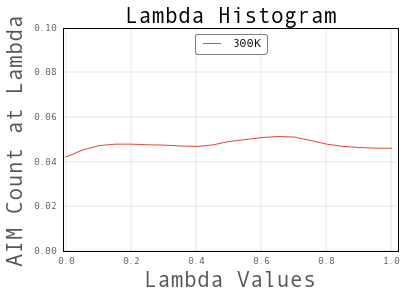

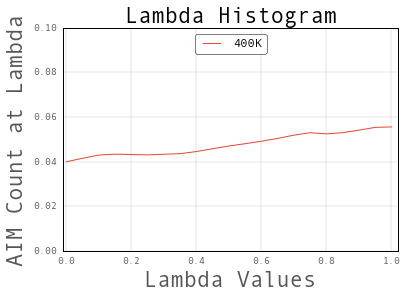

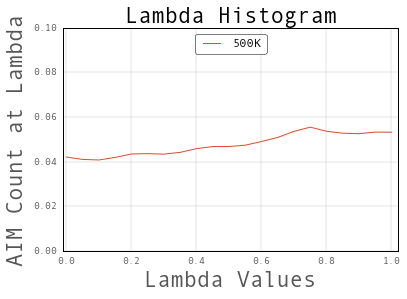

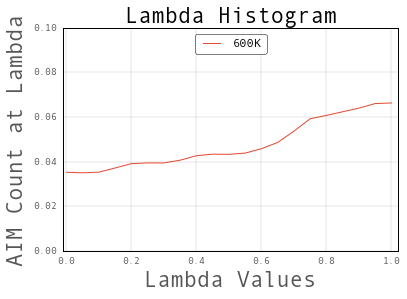

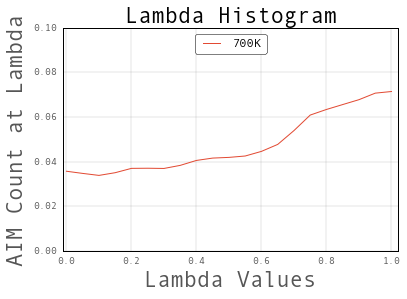

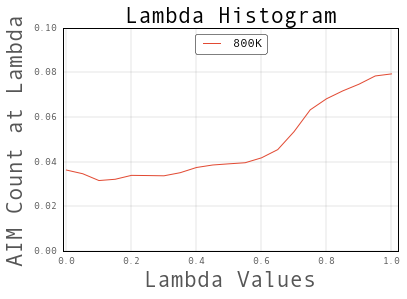

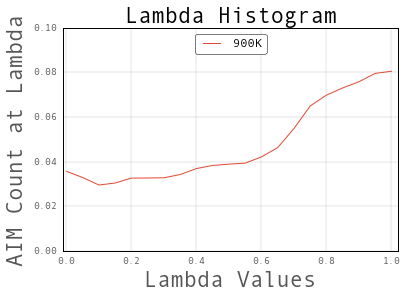

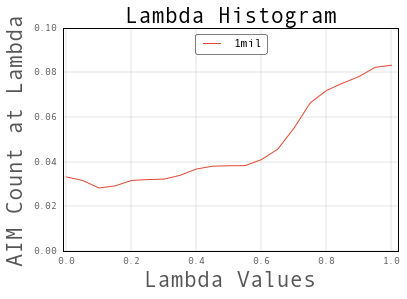

In [23]:
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]

for j in [1,2,3,4,5,6,7,8,9]:
    file_in = "/Users/ChrisM/Documents/workspace/histo{0}00k.log".format(j)
    myHisto = pd.read_csv(
        file_in, 
        header = None,
        names = names,
        comment = '#',
        delim_whitespace=True)
    #counts = myHisto['AIMCount'].astype(np.float)
    chi = np.array(myHisto['AIMCount'])
    counts = [float(i)/chi.sum() for i in chi]
    plt.title("Lambda Histogram", fontsize=22)
    plt.grid(True)
    plt.grid(color='gray', linestyle='-', linewidth=0.2)
    plt.xlabel("Lambda Values", fontsize=22)
    plt.ylabel("AIM Count at Lambda", fontsize=22)
    plt.xlim(-0.01,1.02)
    plt.ylim(0, 0.1)
    x = np.linspace(0,1,len(counts))
    y = counts
    plt.plot(x, y,label=str(j)+"00K")
    legend = plt.legend(loc='upper center')
    plt.show()
    
file_in = "/Users/ChrisM/Documents/workspace/histo1milsteps.log"
myHisto = pd.read_csv(
    file_in, 
    header = None,
    names = names,
    comment = '#',
    delim_whitespace=True)
chi = np.array(myHisto['AIMCount'])
counts = [float(i)/chi.sum() for i in chi]
plt.title("Lambda Histogram", fontsize=22)
plt.grid(True)
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("Lambda Values", fontsize=22)
plt.ylabel("AIM Count at Lambda", fontsize=22)
plt.xlim(-0.01,1.02)
plt.ylim(0, 0.1)
x = np.linspace(0,1,len(counts))
y = counts
plt.plot(x, y,label="1mil")
legend = plt.legend(loc='upper center')
plt.show()

https://dasher.wustl.edu/chem478/reading/jcompphys-22-245-76.pdf
http://www.bevanlab.biochem.vt.edu/Pages/Personal/justin/gmx-tutorials/free_energy/07_analysis.html
The flatness is monotonically decreasing while the acceptance ratio is monotonically increasing.
Plot the flatness as a function of steps and as a function of delta G.
Plot the acceptance ratio as a function of steps.
Plot the free energy difference between neighboring values of λ.